In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt

In [3]:
x = np.loadtxt('ex5Linx.dat')
y = np.loadtxt('ex5Liny.dat')

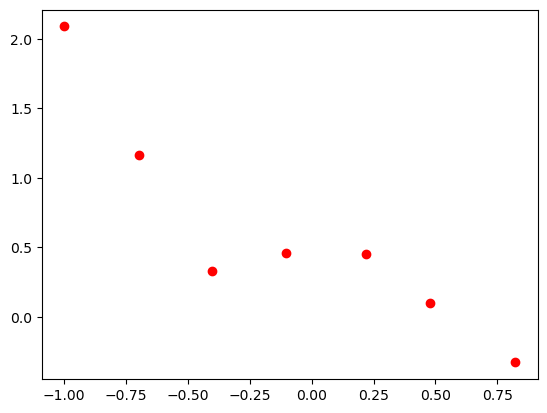

In [5]:
plt.plot(x, y, 'ro')
plt.show()
# print(x, y)

0 tensor([ 0.4726,  0.6814, -1.3803, -5.9780,  2.4419,  4.7374])
1 tensor([ 0.3242, -0.4204,  0.1891, -0.3953,  0.1972, -0.3359])
10 tensor([ 0.1990, -0.1909,  0.1250, -0.1588,  0.1143, -0.1400])


/tmp/ipykernel_2465920/2848019939.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


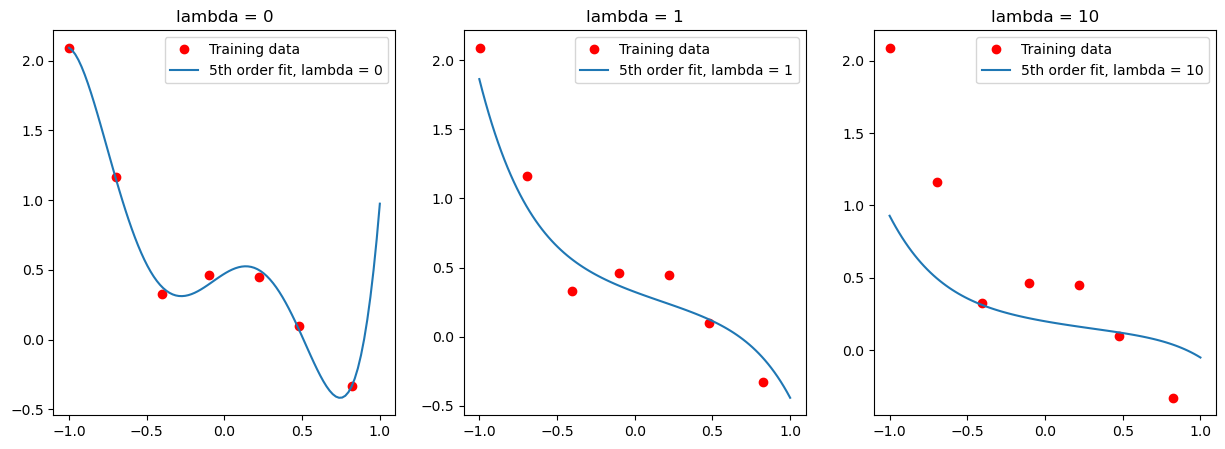

In [22]:
X = np.zeros((len(x), 6))

for i in range(len(x)):
    for j in range(6):
        X[i, j] = x[i] ** j

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for index, lam in enumerate([0, 1, 10]):
    theta = torch.inverse(X.t() @ X + lam * torch.eye(6)) @ X.t() @ y
    print(lam, theta)
    x_plot = np.linspace(-1, 1, 100)
    y_plot = np.zeros(100)
    for i in range(100):
        for j in range(6):
            y_plot[i] += theta[j] * x_plot[i] ** j

    ax[index].plot(x, y, 'ro')
    ax[index].plot(x_plot, y_plot)
    ax[index].set_title(f"lambda = {lam}")
    ax[index].legend(['Training data', f'5th order fit, lambda = {lam}'])

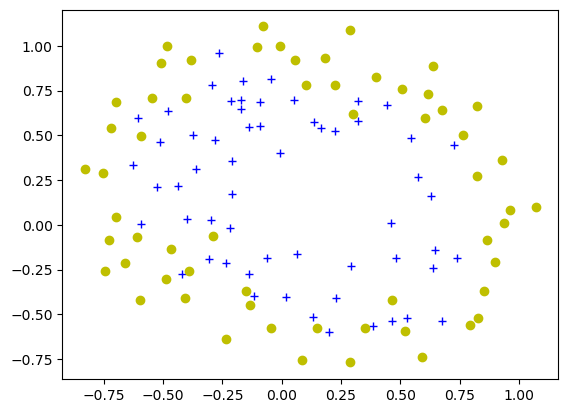

In [39]:
x = np.loadtxt('ex5Logx.dat')
y = np.loadtxt('ex5Logy.dat')

pos = np.where(y > 0)
neg = np.where(y == 0)

plt.plot(x[pos, 0], x[pos, 1], 'b+')
plt.plot(x[neg, 0], x[neg, 1], 'yo')
plt.show()

In [40]:
u, v = x[:, 0], x[:, 1]

from map_feature import map_feature
X = map_feature(u, v)

X

array([[ 1.00000000e+00,  5.12670000e-02,  6.99560000e-01, ...,
         6.29470940e-04,  8.58939846e-03,  1.17205992e-01],
       [ 1.00000000e+00, -9.27420000e-02,  6.84940000e-01, ...,
         1.89305413e-03, -1.39810280e-02,  1.03255971e-01],
       [ 1.00000000e+00, -2.13710000e-01,  6.92250000e-01, ...,
         1.04882142e-02, -3.39734512e-02,  1.10046893e-01],
       ...,
       [ 1.00000000e+00, -5.93890000e-01,  4.94880000e-01, ...,
         2.11549321e-02, -1.76281008e-02,  1.46892430e-02],
       [ 1.00000000e+00, -4.84450000e-01,  9.99270000e-01, ...,
         2.34007252e-01, -4.82684337e-01,  9.95627986e-01],
       [ 1.00000000e+00, -6.33640000e-03,  9.99270000e-01, ...,
         4.00328554e-05, -6.31330588e-03,  9.95627986e-01]])

In [48]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost(theta, x, y):
    m = len(y)
    h = sigmoid(x @ theta)
    return -1 / m * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))

class Optimizer:
    def __init__(self, x: np.ndarray, y: np.ndarray, theta: np.ndarray):
        self.x = x
        self.y = y
        self.theta = theta
    
    def forward(self, lam: float):
        m = len(self.y)
        h = sigmoid(self.x @ self.theta)
        return (
            -1 / m * (self.y.T @ np.log(h) + (1 - self.y).T @ np.log(1 - h))
        ) + (lam / (2 * m) * self.theta[1:].T @ self.theta[1:])
    
    def step(self, lam: float): # using newton's method
        m = len(self.y)
        h = sigmoid(self.x @ self.theta)
        grad = 1 / m * self.x.T @ (h - self.y) \
            + lam / m * np.concatenate([[0], self.theta[1:]])
        hessian = 1 / m * self.x.T @ np.diag(h) @ np.diag(1 - h) @ self.x \
            + lam / m * np.diag(np.concatenate([[0], np.ones(len(self.theta) - 1)]))
        self.theta -= np.linalg.inv(hessian) @ grad

/tmp/ipykernel_2465920/2109498097.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i, j] = map_feature(np.array([u[i]]), np.array([v[j]])).dot(theta)


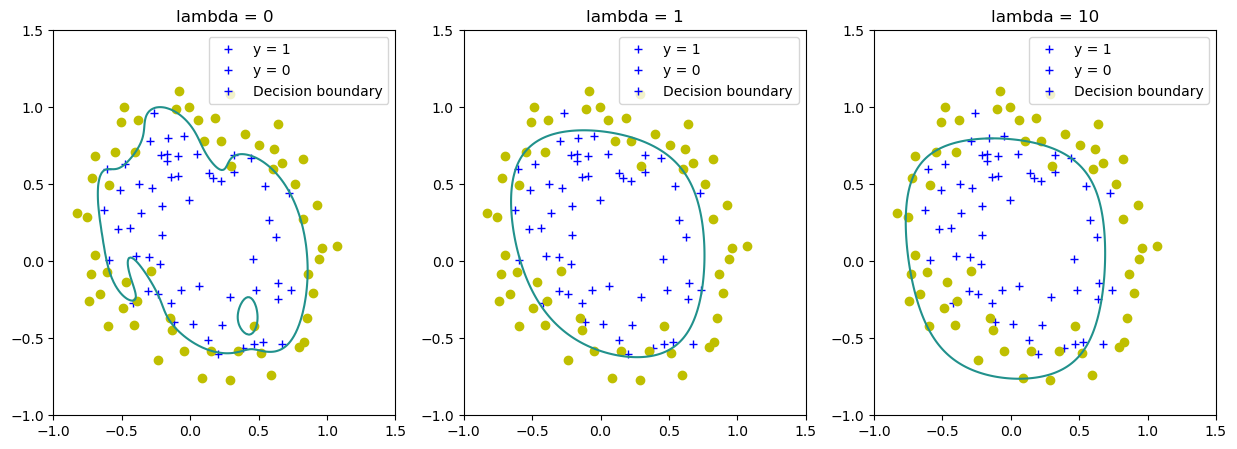

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for index, lam in enumerate([0, 1, 10]):
    theta = np.zeros(X.shape[1])
    optimizer = Optimizer(X, y, theta)
    for i in range(100):
        optimizer.step(lam)

    u = np.linspace(-1, 1.5, 200)
    v = np.linspace(-1, 1.5, 200)
    z = np.zeros((len(u), len(v)))

    for i in range(len(u)):
        for j in range(len(v)):
            z[i, j] = map_feature(np.array([u[i]]), np.array([v[j]])).dot(theta)

    z = z.T
    ax[index].plot(x[pos, 0], x[pos, 1], 'b+')
    ax[index].plot(x[neg, 0], x[neg, 1], 'yo')
    ax[index].contour(u, v, z, 0)
    ax[index].set_title(f"lambda = {lam}")
    ax[index].legend(['y = 1', 'y = 0', 'Decision boundary'])
